# Optimization and gradient descent

Toy example demonstrating optimization via gradient descent with a simple, easy-to-visualize function.

## Notebook set-up

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem statement

Dr. P is tired of grading hundreds of labs, problems sets & exams. But, while looking at grades for past semesters, he noticed an interesting phenomenon - there seems to be a strong correlation between attendance and final grade. Maybe we can use a student's attendance to predict there score.

## 2. Goal

Write a custom optimization function to fit a linear model to the provided data.

The goal of this mini-project is to get you thinking about optimization - how do we fit a model to data? How do we quantify 'how good' a model is? The best way to think deeply about a topic is start with a tractable example and think it though.

## 3. Data

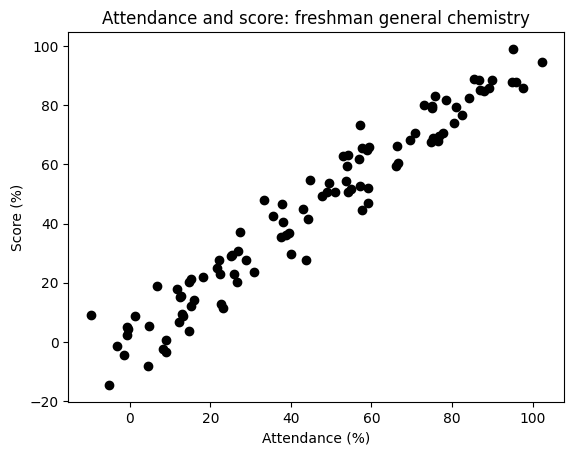

In [ ]:
n = 100
noise_width = 5
attendance = np.array(list(range(n))) + np.random.normal(-noise_width, noise_width, n)
score = np.array(list(range(n))) + np.random.normal(-noise_width, noise_width, n)

plt.title('Attendance and score: freshman general chemistry')
plt.scatter(attendance, score, color='black')
plt.xlabel('Attendance (%)')
plt.ylabel('Score (%)')
plt.show()

## 4. Model functions

Write two functions:

1. **Linear model**: function that accepts three arguments: a list of attendance values, a slope ('m' parameter) and a y-intercept ('b' parameter). The function should then use these three arguments to calculate and return a list of scores.
2. **Error function**: takes list of true scores and list of predicted scores from the linear model as arguments. Calculates the average of the difference between the true and predicted value for each student.

**Hint**: square or take the absolute value of each difference before averaging them - this prevents the tendency of negative and positive error values to cancel out.

### 4.1. Linear model

In [ ]:
def linear_model():
    # Your code here

### 4.2. Error function

In [ ]:
def error_function():
    # Your code here

## 5. Optimizer

Write an optimization function which iteratively tries different values of m and b. The function should calculate the error for a given parameter set (choice of m and b), then update those values based on the size of the error. Along the way, the function should keep the 'winning' values and then return the best parameters at the end. Here are the rough steps the loop should follow:

1. Pick values for m and b
2. Call the linear model to get predictions for all of the student's scores
3. Call the error function to calculate the error of the predictions relative to the true values
4. Decide how much and in which direction to change the values of m and b
5. Repeat

**Hints**: 
1. Look at the toy data - is it visually obvious what the value of b should be? If you can, set b to a constant. This way you only have to optimize m.
2. Keep a 'memory' of the values you have tried so far and their error values.


In [ ]:
def optimizer(attendance, score, linear_model, error_function):
    # Your code here

## 6. Results

Plot the following:

1. The final linear model and the grade data on the same plot. How good is the model? Is it a good idea to use this when grading students?
2. The value of m vs the error for all of the values sampled during optimization. Is this the 'best' model? How could the algorithm be improved. Could we make it faster/more efficient?